<a href="https://colab.research.google.com/github/Yujini68/ESAA/blob/main/%EA%B3%BC%EC%A0%9C_1115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 04 모델 세부 설정

앞에서 다룬 mnist 데이터셋 다시 사용

데이터 정규화까지 처리하여 입력 데이터 준비

In [1]:
import tensorflow as tf

#케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist=tf.keras.datasets.mnist

#load_data()로 데이터셋 로드
(x_train, y_train),(x_test, y_test)=mnist.load_data()

#로드된 데이터셋 확인
print('train set:',x_train.shape, y_train.shape)
print('test set:', x_test.shape, y_test.shape)

#데이터 정규화
x_train=x_train/x_train.max() #max:255
x_test=x_test/x_test.max() #max:255

train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


### 4-1 초기값 설정

레이어의 초기화 방법을 다르게 설정 가능


In [2]:
dense = tf.keras.layers.Dense(256, activation="relu")
dense.get_config()["kernel_initializer"]

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

In [3]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer="he_normal", activation ="relu")
print(dense.get_config()["kernel_initializer"])

{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}


In [4]:
# 클래스 인스터스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation="relu")
print(dense.get_config()["kernel_initializer"])

{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}


케라스에서 지원하는 자주 사용되는 초기화 목록

- 글로럿 초기화
- Yann Lecun 초기화
- He 초기화
- 정규분포,연속균등 분포 초기화

### 4-2 규제

모델의 과대적합을 해소하기 위해 L1, L2 규제를 적용

텐서플로 케라스 레이어는 기본값으로 규제를 적용하지 않음

-> 레이어에 규제를 적용하기 위해서는 별도로 설정

In [5]:
# 기본값
dense = tf.keras.layers.Dense(256, activation="relu")
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [6]:
# L1 규제 적용

dense = tf.keras.layers.Dense(256, kernel_regularizer="l1", activation="relu")
print(dense.get_config()["kernel_regularizer"])

{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.009999999776482582}, 'registered_name': None}


In [7]:
# 클래스 인스턴스 적용, alpha=0.1 변경

regularizer = tf.keras.regularizers.l1(l1=0.1)
dense = tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation="relu")
print(dense.get_config()["kernel_regularizer"])

{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.10000000149011612}, 'registered_name': None}


### 4-3 드롭아웃

과대적합 문제 : 딥러닝 모델의 층이 넓고 깊어질 때 모델은 훈련에 주어진 샘플에 과하게 적합하도록 학습하는 경향이 있음

-> 훈련할 때 만나지 못한 새로운 데이터에 대해서는 좋지 않는 예측력을 보일 때가 많음, 훈련 데이터셋에 너무 적응하여 검증 데이터셋이나 테스트 데이터셋에 대해 일반화된 성능을 갖지 못하는 문제가 자주 발생하는 편

드롭아웃은 모델의 과대적합 문제를 해결하기 위해 제안된 아이디어, 실무적으로 상당히 좋은 효과를 보이는 것으로 알려져 있

노드의 일부 신호를 임의로 삭제하게 되면, 모델이 쉽게 과대적합 되는 것을 방지할 수 있음, 모델이 학습하는 가중치 파라미터의 개수가 현저하게 줄어들게 되기 때문

모델이 훈련할 때는 드롭아웃이 적용되어 노드 중 일부만 훈련하게 되지만, 예측 시점에는 모든 노드들이 활용됨

In [8]:
# Dropout 25% 비율 적용 (25%의 노드가 삭제)
tf.keras.layers.Dropout(0.25)

<Dropout name=dropout, built=False>

### 4-4 배치 정규화

각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화

-> 다음층으로 데이터가 전달되기 전에 스케일을 조정하기 때문에 보다 안정적인 훈련이 가능하고 성능을 크게 향상시킬 수 있음

In [9]:
#Model A: Dense+ReLU
model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

model_a.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#Model B: Dense + BatchNorm + ReLU
model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(32),
     # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(10,activation="softmax")

])

model_b.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,034 (207.16 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

### 4-5 활성화 함수

클래스 인스턴스로 선언하여 하이퍼파라미터 값을 변경하여 적용

In [11]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


<LeakyReLU name=leaky_re_lu_1, built=False>

In [12]:
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(32),
     # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(10,activation="softmax"),

])

model_c.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,034 (207.16 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

앞에서 생성한 2개의 모델과 LeakyReLU 활성화 함수로 변경한 모델까지 더해서 총 3개의 모델을 동일한 조건으로 10번의 에포크 동안 훈련한 후에 수렴 속도를 확인

- model_a : Dense레이어 + ReLU 활성화함수

- model_b : Dense레이어 + 배치 정규화

- model_c : Dense레이어 + 배치 정규화 + LeakyReLU(0.2) 활성화함수

In [13]:
model_a.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_b.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_c.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_a = model_a.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=10)
history_b = model_b.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=10)
history_c = model_c.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8647 - loss: 0.4812 - val_accuracy: 0.9547 - val_loss: 0.1511
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9578 - loss: 0.1397 - val_accuracy: 0.9616 - val_loss: 0.1214
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9712 - loss: 0.0975 - val_accuracy: 0.9676 - val_loss: 0.1054
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9752 - loss: 0.0794 - val_accuracy: 0.9728 - val_loss: 0.0950
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9792 - loss: 0.0637 - val_accuracy: 0.9727 - val_loss: 0.0921
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9835 - loss: 0.0531 - val_accuracy: 0.9718 - val_loss: 0.0939
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9847 - loss: 0.0465 - val_accuracy: 0.9740 - val_loss: 0.0890
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9876 - loss: 0.0378 - 

epoch별 검증 손실의 감소 추이 확인 가능

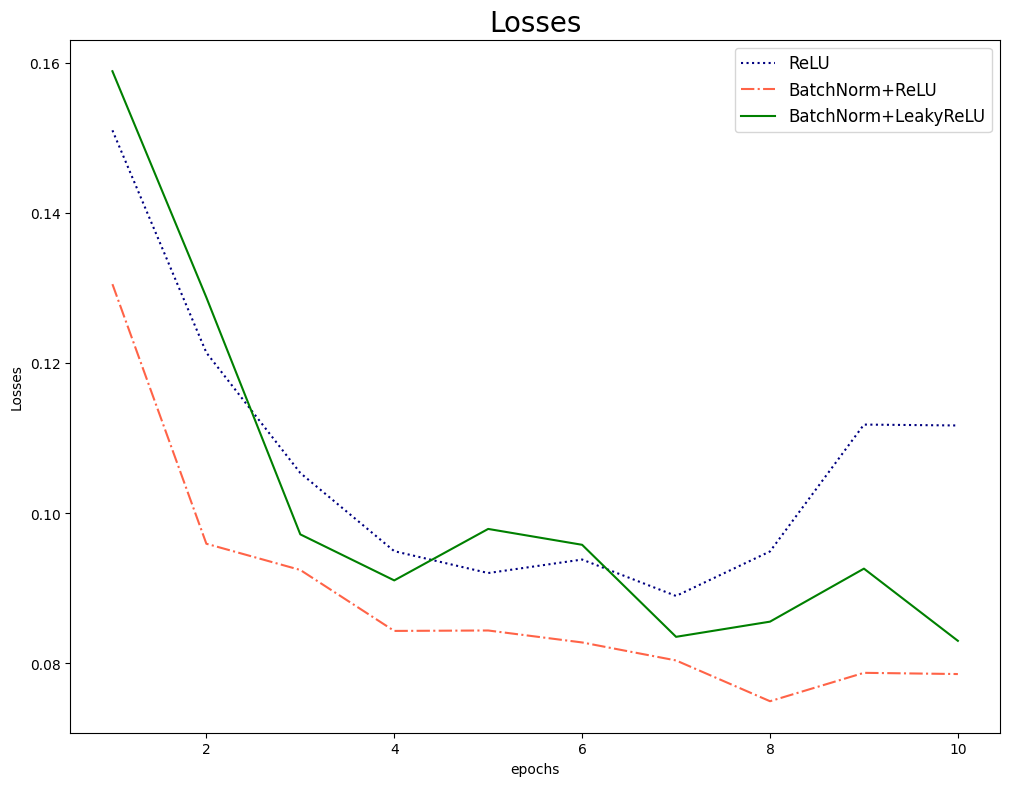

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,9))
plt.plot(np.arange(1,11), history_a.history["val_loss"],color="navy",linestyle=":")
plt.plot(np.arange(1,11), history_b.history["val_loss"],color="tomato",linestyle="-.")
plt.plot(np.arange(1,11), history_c.history["val_loss"],color="green",linestyle="-")

plt.title("Losses",fontsize=20)
plt.xlabel("epochs")
plt.ylabel("Losses")
plt.legend(["ReLU","BatchNorm+ReLU","BatchNorm+LeakyReLU"],fontsize=12)

minist 데이터셋은 모델별 차이 크지 않음

더 복잡한 데이터셋은 배치 정규화와 다른 활성화 함수를 적용해 보면서 모델의 훈련 추이를 관찰해 볼 필요가 있음

## 06 모델 저장 및 불러오기

### 6-1 모델을 파일로 저장

In [21]:
# 모델을 h5 포맷으로 저장
model_c.save('h5-model.h5')

### 6-2 저장된 모델 복원

In [22]:
#모델복원
h5_model = tf.keras.models.load_model("h5-model.h5")
h5_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,036 (207.18 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

복원한 모델을 검증하여 복원이 잘 되었는지 확인

검증 셋을 evaluate 함수에 대입해, 손실함수와 평가지표 계산

In [23]:
#모델 검증
loss,acc=h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5model]loss:{loss:5f},acc:{acc:5f}')

h5model]loss:0.083018,acc:0.974300


In [27]:
# 모델을 SavedModel 포맷으로 저장
model_c.save('saved-model.h5')

In [29]:
#모델복원
saved_model=tf.keras.models.load_model('saved-model.h5')
saved_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,036 (207.18 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

In [30]:
#모델 검증(HDF5 포맷)
loss,acc=h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5model]loss:{loss:5f},acc:{acc:5f}')

#모델 검증(SavedModel 포맷)
loss,acc=saved_model.evaluate(x_test, y_test, verbose=0)
print(f'saved_model]loss:{loss:5f},acc:{acc:5f}')

h5model]loss:0.083018,acc:0.974300
saved_model]loss:0.083018,acc:0.974300


## 07 복잡한 모델 생성

### 7-1 함수형 API

함수 형태로 딥러닝 모델을 정의하면 다양한 모델 구조를 구현 가능

ex. 함수의 입력 매개변수를 여러 개 갖는 다중 입력, 함수의 return 값을 여러 개 갖는 다중 출력, 같은 레벨에 여러 개의 층을 배치하여 입력과 출력을 공유하는 구조

Sequential API를 사용하는 경우 단방향의 Sequential 모델만 구현할 수 있다는 제약이 있음

데이터 흐름이 특정 레이어를 건너뛰거나, 병합 및 분리하는 등의 구조의 모델을 구현할 수는 없음

함수형 API를 사용하기 위해서는 먼저 Input 레이어를 정의 -> Input레이어에 데이터의 입력 shape을 정의 -> 레이어마다 반환되는 출력 값을 변수에 저장한 뒤 다음 레이어의 입력으로 연결 -> 여러 개의 레이어를 마치 체인 구조로 입출력을 계속 연결 가능



In [31]:
#모델의 레이어를 체인 구조로 연결 Input 레이어 정의
input_layer=tf.keras.Input(shape=(28,28),name='InputLayer')

#모델의 레이어를 체인 구조로 연결x2=tf.keras.
x1=tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2=tf.keras.layers.Dense(256, activation='relu',name='Dense1')(x1)
x3=tf.keras.layers.Dense(64, activation='relu',name='Dense2')(x2)
x4=tf.keras.layers.Dense(10, activation='softmax',name='OutputLayer')(x3)

체인방식으로 연결한 후에 입력 레이어와 출력 레이어를 정의하여 모델을 생성

In [32]:
#모델 생성
func_model=tf.keras.Model(inputs=input_layer,outputs=x4, name='FunctionalModel')

#모델 요약
func_model.summary()

Model: "FunctionalModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense2 (Dense)                       │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

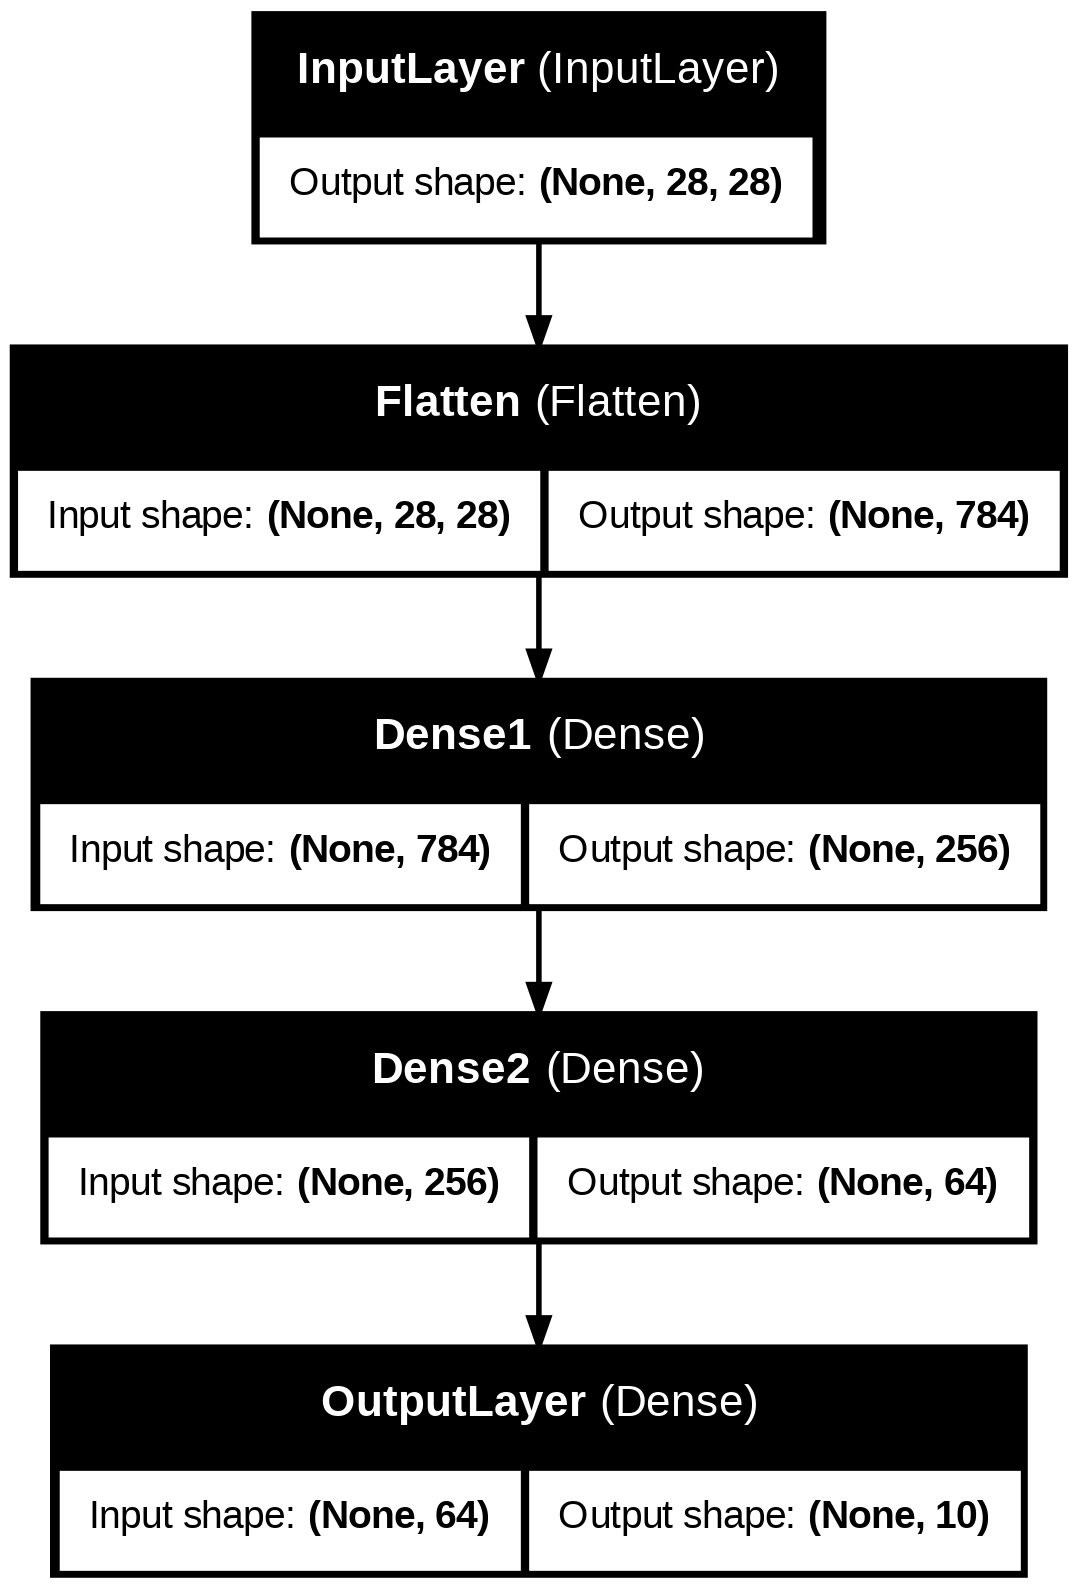

In [33]:
from tensorflow.keras.utils import plot_model

#구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [34]:
#컴파일
func_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

#훈련
func_model.fit(x_train, y_train, epochs=3)

#검증
loss,acc=func_model.evaluate(x_test, y_test, verbose=0)
print(f'Functional Model]loss:{loss:5f},acc:{acc:5f}')

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8904 - loss: 0.3672
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9710 - loss: 0.0914
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9807 - loss: 0.0601
Functional Model]loss:0.086404,acc:0.973400


### 7-2 모델 서브클래싱

텐서플로 케라스에서 제공하는 model 클래스를 기반으로 딥러닝 모델을 구현

이 클래스를 직접 상속받아 사용자가 서브클래스로 딥러닝 모델 만들 수 있음


In [35]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256,activation='relu')
        self.dense2 = tf.keras.layers.Dense(64,activation='relu')
        self.dense3 = tf.keras.layers.Dense(10,activation='softmax')

    # method overiding
    # 훈련용 함수 정의
    # x는 input
    def call(self,x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [36]:
# 모델 생성
mymodel = MyModel()
# 모델의 이름 설정
mymodel._name = "subclass_model"
# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28,28)))
# 모델 요약
mymodel.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
#컴파일
mymodel.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#훈련
mymodel.fit(x_train,y_train, epochs=3)

#검증
loss, acc = mymodel.evaluate(x_test,y_test,verbose=0)
print(f"Subclassing Model]loss:{loss:.5f}.acc:{acc:.5f}")

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8864 - loss: 0.3902
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9719 - loss: 0.0912
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9811 - loss: 0.0595
Subclassing Model]loss:0.07913.acc:0.97450


### 7-3 서브클래싱 모델 파라미터를 활용한 생성

Model Subclassing의 장점 :

생성자 파라미터로 모델 내부 레이어의 하이퍼파라미터를 지정할 수 있음

In [43]:
class MyModel(tf.keras.Model):

    # 생성자 파라미터 추가
    def __init__(self, units, num_classes):
        super(MyModel,self).__init__()
        #초기값 설정
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units,activation='relu')
        self.dense2 = tf.keras.layers.Dense(units/4,activation='relu')
        self.dense3 = tf.keras.layers.Dense(num_classes,activation='softmax')

    # class overiding
    # 훈련용 함수 정의
    # x는 input
    def call(self,x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [ ]:
# 모델 생성
mymodel = MyModel(256,10)

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28,28)))

# 모델 요약
mymodel.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  200960    
                                                                 
 dense_19 (Dense)            multiple                  16448     
                                                                 
 dense_20 (Dense)            multiple                  650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 컴파일
mymodel.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# 훈련
mymodel.fit(x_train,y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test,y_test,verbose=0)
print(f"Subclassing Model w.parameters]loss:{loss:.5f}.acc:{acc:.5f}")

Epoch 1/3
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2176 - accuracy: 0.9351
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0895 - accuracy: 0.9727
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0604 - accuracy: 0.9804
Subclassing Model w.parameters]loss:0.06668.acc:0.97840
